# Pollution in Vigo during the coronavirus outbreak
It has been reported that the state of lockdown and decreased traffic due to the coronavirus outbreak has improved the pollution situacion in many big cities such as Beijing, Tokio, Madrid, Barcelona... Is this also true for my own (way smaller) city? Let's find out!

In [275]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk
from datetime import date, timedelta

sns.set_style('whitegrid')

After looking into meteogalicia's documentation, I found out that their air contamination data could be accessed by sending requests to one of their JSON files passing it certain parameters. One of those parameters is the date, which must have a certain format, so I created a list of properly formatted dates to be able to easily use them later.

I wanted to get all of the daily information since the start of 2017, to have at least three years to compare 2020 with.

In [2]:
sdate = date(2017, 1, 1)   # start date
#edate = date.today()      # end date

edate = date.today()  # end date

delta = edate - sdate      # as timedelta

date_list = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    date_list.append(day.strftime("%d/%m/%Y"))
    
date_list[:5]

['01/01/2017', '02/01/2017', '03/01/2017', '04/01/2017', '05/01/2017']

Using this list of dates and setting the ```idZona``` parameter to 7, which is Vigo's code, we can get all of the JSON content that we're looking for as individual JSON objects (on for each day) and put them in a list.

In [3]:
json_list = []
for day in date_list:
    payload = {'idZona':'7',
               'data':day}
    r = requests.get('http://servizos.meteogalicia.es/rss/observacion/listaEstacionsCA.action',
                 params=payload)
    json_list.append(r.json())

Since I haven't found any other way to do it, this implies making more than 1000 GET requests to poor meteogalicia's JSON, so to avoid running this part more than necessary, I define a pair of functions that save all of the JSON files locally and load them when necessary.

In [3]:
def save_json_list(json_list):
    for i, json_file in enumerate(json_list):
        fecha = json_file['datosZona'][0]['fecha']
        formatted_fecha = pd.to_datetime(fecha, dayfirst=True).date()
        filename = "./jsons/dia_{}.json".format(formatted_fecha)
        with open(filename, 'w') as open_file:
            json.dump(json_file, open_file)
            
def rebuild_json_list():
    mypath = "./jsons/"

    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break

    json_list = []
    for filename in sorted(f):
        with open(mypath + filename, 'r') as open_file:
            json_list.append(json.load(open_file))
    print(
    return json_list

In [4]:
json_list = rebuild_json_list()

All set! Let's start looking into how the JSON files are structured and how can we get to our data.

In [272]:
json_list[0]['datosZona'][0]

{'fecha': '01/01/2017',
 'hora': '13:00',
 'icas': [{'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'SO2',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.01'},
  {'calculo': 'O',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'CO',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.028'},
  {'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'NO2',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.19'},
  {'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'PM10',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.36'},
  {'calculo': 'H',
   'estacion': 'Vigo - Coia',
   'fecha': '01/01/2017',
   'hora': '13:00',
   'parametro': 'O3',
   'textoValor': 'Boa',
   'valor': '0',
   'valorIca': '0.17'},
  {'calculo': 'H',
   'estacion': '

It looks like each element inside 'datosZona' corresponds to an hour of the day, and that each hour of the day has measurements for all of the studied gases at the two stations in Vigo (Coia and Lope de Vega)

In [32]:
print("Total days: {}\n"
      "Entries per day: {}\n".format(len(json_list), len(json_list[0]['datosZona'])))

Total days: 1176
Entries per day: 25



What hours correspond to these 25 entries? Shouldn't it be 24?

In [25]:
hours = []
for hour in json_list[300]['datosZona']:
    hours.append(hour['hora'])
print(hours)

print(json_list[300]['datosZona'][0]['fecha'])
print(json_list[300]['datosZona'][-1]['fecha'])

['13:00', '12:00', '11:00', '10:00', '09:00', '08:00', '07:00', '06:00', '05:00', '04:00', '03:00', '02:00', '01:00', '00:00', '23:00', '22:00', '21:00', '20:00', '19:00', '18:00', '17:00', '16:00', '15:00', '14:00', '13:00']
28/10/2017
27/10/2017


Aha! Looks like that last measurement is a second 13:00. If we look further into it, we can see that it actually corresponds to the previous day!
We will exclude it from now on.

Let's take a look at what the measurements represent.

In [29]:
print(json_list[0]['datosZona'][0]['icas'][0])
print()

for ica in json_list[0]['datosZona'][0]['icas']:
    print(ica['estacion'], ica['parametro'], ica['valorIca'])

{'calculo': 'H', 'estacion': 'Vigo - Coia', 'fecha': '01/01/2017', 'hora': '13:00', 'parametro': 'SO2', 'textoValor': 'Boa', 'valor': '0', 'valorIca': '0.01'}

Vigo - Coia SO2 0.01
Vigo - Coia CO 0.028
Vigo - Coia NO2 0.19
Vigo - Coia PM10 0.36
Vigo - Coia O3 0.17
Vigo - Lope de Vega SO2 0.0
Vigo - Lope de Vega CO 0.039
Vigo - Lope de Vega NO2 0.27
Vigo - Lope de Vega PM10 0.24
Vigo - Lope de Vega O3 0.16


It looks like each hour element includes 10 measurements, 5 for each one of Vigo's two stations, representing 5 different pollutants.

Let's check if this is consistent in all of the entries!

In [274]:
print_list = []

for day in json_list:
    for hour in day['datosZona'][:-1]:
        if len(hour['icas']) == 10:
            pass
        else:
            print_list.append("Hour {} of day {} has {} measurements".format(hour['hora'], hour['fecha'], len(hour['icas'])))

for line in print_list[:10]:
    print(line)

Hour 04:00 of day 26/03/2017 has 16 measurements
Hour 13:00 of day 06/05/2017 has 5 measurements
Hour 12:00 of day 06/05/2017 has 6 measurements
Hour 11:00 of day 06/05/2017 has 6 measurements
Hour 10:00 of day 06/05/2017 has 6 measurements
Hour 09:00 of day 06/05/2017 has 6 measurements
Hour 08:00 of day 06/05/2017 has 6 measurements
Hour 07:00 of day 06/05/2017 has 6 measurements
Hour 06:00 of day 06/05/2017 has 6 measurements
Hour 13:00 of day 07/05/2017 has 5 measurements


Well... It looks like quite a number of entries have either fewer or more measurements than the expected 10. Therefore, we should be able to handle missing values.

Right now, I'm interested in getting a single value for each of the different measurements for each day by getting the maximum of all of the measurements of the day.

Let's define a function to extract the measurements from each hour, and another one to aggregate them and get a single value for each gas in each station and day.

In [195]:
def read_hour(hour):
    meas_dict = {
        ('Vigo - Coia', 'SO2'):'SO2_c',
        ('Vigo - Coia', 'CO'):'CO_c',
        ('Vigo - Coia', 'NO2'):'NO2_c',
        ('Vigo - Coia', 'PM10'):'PM10_c',
        ('Vigo - Coia', 'O3'):'O3_c',
        ('Vigo - Lope de Vega', 'SO2'):'SO2_ldv',
        ('Vigo - Lope de Vega', 'CO'):'CO_ldv',
        ('Vigo - Lope de Vega', 'NO2'):'NO2_ldv',
        ('Vigo - Lope de Vega', 'PM10'):'PM10_ldv',
        ('Vigo - Lope de Vega', 'O3'):'O3_ldv'
    }
    values_dict = {}
    for key, value in meas_dict.items():
        values_dict[value] = 0 # Fills the spaces in the dictionary with zeros. If any measurement is missing, its spot in the dictionary just stays 0
    for ica in hour['icas']:
        if float(ica['valorIca']) > 0:
            values_dict[meas_dict[(ica['estacion'], ica['parametro'])]] = float(ica['valorIca']) # If there's any duplicate measurement, it just gets
                                                                                                 # assigned many times to a single dictionary key
        else:
            pass
    return values_dict
        
def read_day(day):
    value_list = []
    for hour in day[:-1]:
        values = [value for key, value in read_hour(hour).items()]
        value_list.append(values)
    try:
        return np.max(np.array(value_list), axis=0) # The aggregate value is the maximum in that day
    except TypeError:
        return value_list

read_day(json_list[84]['datosZona'])

array([0.011, 0.048, 0.24 , 0.2  , 0.55 , 0.01 , 0.015, 0.35 , 0.17 ,
       0.65 ])

A little test to check if the new functions trigger any errors in any particular day:

In [197]:
for i, day in enumerate(json_list):
    try:
        read_day(day['datosZona'])
    except:
        print(i)

And now, we finally create a tidy and convenient data frame!

In [241]:
raw_data = []
dates = []
for i, day in enumerate(json_list):
    try:
        row = read_day(day['datosZona'])
        raw_data.append(row)
        dates.append(json_list[i]['datosZona'][0]['fecha'])
    except TypeError:
        print("{} failed".format(i))
    
df = pd.DataFrame(raw_data,
                  columns=[
                     'SO2_c',
                     'CO_c',
                     'NO2_c',
                     'PM10_c',
                     'O3_c',
                     'SO2_ldv',
                     'CO_ldv',
                     'NO2_ldv',
                     'PM10_ldv',
                     'O3_ldv',
                     ],
                    dtype='float')
df.insert(0, 'data', pd.to_datetime(dates, dayfirst=True)) # Convert the date column (str type) to pd.datetime type
df.index = df['data'] # Set the date column as a datetime index
df.drop('data', axis=1, inplace=True)
df.head()

,SO2_c,CO_c,NO2_c,PM10_c,O3_c,SO2_ldv,CO_ldv,NO2_ldv,PM10_ldv,O3_ldv
data,,,,,,,,,,
2017-01-01,0.027,0.093,0.59,3.00,0.37,0.0,0.039,0.27,1.10,0.16
2017-01-02,0.016,0.036,0.40,0.44,0.39,0.0,0.039,0.27,0.36,0.19
2017-01-03,0.011,0.015,0.37,0.23,0.45,0.0,0.039,0.35,0.15,0.47
2017-01-04,0.016,0.021,0.44,0.25,0.29,0.0,0.053,0.45,0.23,0.31
2017-01-05,0.017,0.048,0.47,0.33,0.16,0.0,0.061,0.33,0.31,0.23


In [242]:
df.info() # Check if all of the columns have an appropriate type

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1176 entries, 2017-01-01 to 2020-03-21
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SO2_c     1176 non-null   float64
 1   CO_c      1176 non-null   float64
 2   NO2_c     1176 non-null   float64
 3   PM10_c    1176 non-null   float64
 4   O3_c      1176 non-null   float64
 5   SO2_ldv   1176 non-null   float64
 6   CO_ldv    1176 non-null   float64
 7   NO2_ldv   1176 non-null   float64
 8   PM10_ldv  1176 non-null   float64
 9   O3_ldv    1176 non-null   float64
dtypes: float64(10)
memory usage: 101.1 KB


It's time to start thinking about representations and graphs:

First, let's see how the values of the measurements are distributed for each of the pollutants: are they really close together, is there a lot of variance, are there any outliers?

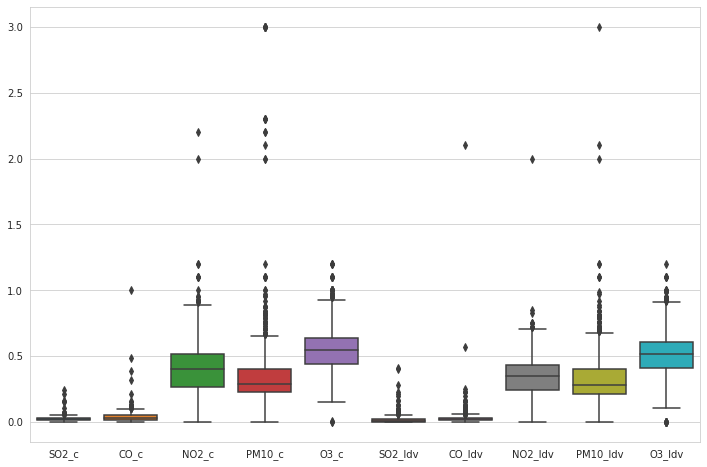

In [244]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(data=df)

Looking at the box plot it becomes apparent that, while most of the values are fairly concentrated around their median values, there are some outliers that lie quite far. These outliers might correspond to errors in the measurements (all of them are taken automatically so there probably aren't any human errors such as typos), or to certain infrequent peaks in the levels of those gases. Since I am trying to describe the general profile, it might be wise to remove them or replace them by average values.

To be able to identify them, I define a simple measure of the dispersion: the interquartile range (IQR), which is equal to the difference between the 75th and 25 percentiles. Then, I set as NaN all of the values that lie above the 75th percentile + 1.5 times the IQR, and below the 25th percentile minus 1.5 times the IQR.

In [264]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))] = np.nan
df.head()

SO2_c       0.0170
CO_c        0.0350
NO2_c       0.2425
PM10_c      0.1600
O3_c        0.1900
SO2_ldv     0.0210
CO_ldv      0.0140
NO2_ldv     0.1900
PM10_ldv    0.1900
O3_ldv      0.2000
dtype: float64


,SO2_c,CO_c,NO2_c,PM10_c,O3_c,SO2_ldv,CO_ldv,NO2_ldv,PM10_ldv,O3_ldv
data,,,,,,,,,,
2017-01-01,0.027,0.093,0.59,NaN,0.37,0.0,0.039,0.27,NaN,0.16
2017-01-02,0.016,0.036,0.40,0.44,0.39,0.0,0.039,0.27,0.36,0.19
2017-01-03,0.011,0.015,0.37,0.23,0.45,0.0,0.039,0.35,0.15,0.47
2017-01-04,0.016,0.021,0.44,0.25,0.29,0.0,NaN,0.45,0.23,0.31
2017-01-05,0.017,0.048,0.47,0.33,0.16,0.0,NaN,0.33,0.31,0.23


Let's take a qualitative look at how many outliers there were by representing the NaN values as a heatmap.

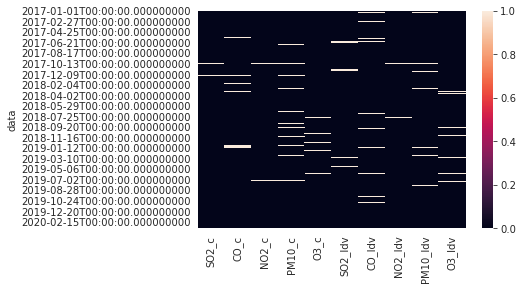

In [247]:
sns.heatmap(pd.isnull(df))

It looks like there aren't many missing values! Nice.

Now, let's fill them out by using a time interpolation.

In [253]:
df.interpolate(method='time', limit_direction='both')

,SO2_c,CO_c,NO2_c,PM10_c,O3_c,SO2_ldv,CO_ldv,NO2_ldv,PM10_ldv,O3_ldv
data,,,,,,,,,,
2017-01-01,0.027,0.093,0.59,0.44,0.37,0.000,0.039000,0.27,0.36,0.16
2017-01-02,0.016,0.036,0.40,0.44,0.39,0.000,0.039000,0.27,0.36,0.19
2017-01-03,0.011,0.015,0.37,0.23,0.45,0.000,0.039000,0.35,0.15,0.47
2017-01-04,0.016,0.021,0.44,0.25,0.29,0.000,0.053000,0.45,0.23,0.31
2017-01-05,0.017,0.048,0.47,0.33,0.16,0.000,0.052333,0.33,0.31,0.23
...,...,...,...,...,...,...,...,...,...,...
2020-03-17,0.031,0.013,0.35,0.15,0.56,0.010,0.020000,0.27,0.20,0.52
2020-03-18,0.053,0.013,0.40,0.23,0.56,0.013,0.048000,0.27,0.31,0.49
2020-03-19,0.053,0.013,0.47,0.35,0.53,0.015,0.045000,0.27,0.41,0.47


Looking at the box plot diagram again, we can see that we have much more compact distributions. This is the result of an approximation and this should be taken into account, but it's an acceptable approach for the purposes of this study.

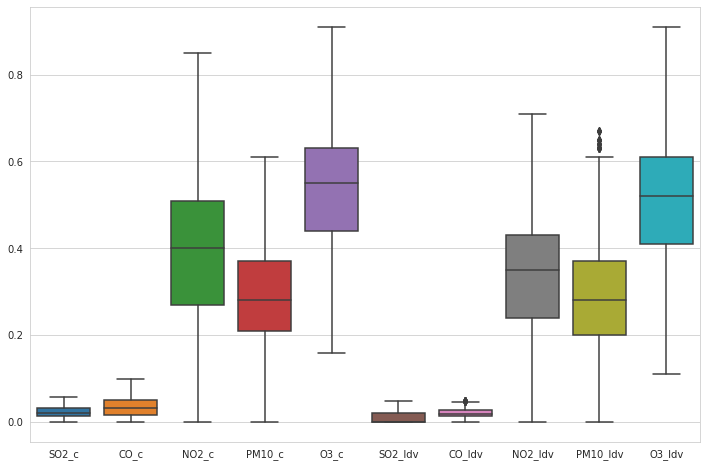

In [265]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(data=df)

Now, I want to see if there's any weekly pattern in the levels of pollutants. It's logical to think that a calm and relaxed Sunday would have less traffic (and therefore less contamination) than a busy work Monday!

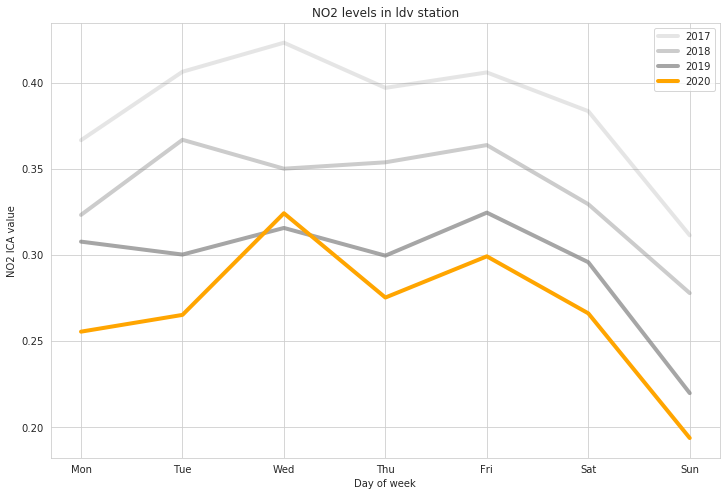

In [270]:
def group_by_dayofweek(df, year):
    return df[df.index.year == year].groupby(df[df.index.year == year].index.dayofweek).mean()

week_2017 = group_by_dayofweek(df, 2017)
week_2018 = group_by_dayofweek(df, 2018)
week_2019 = group_by_dayofweek(df, 2019)
week_2020 = group_by_dayofweek(df, 2020)

def plot_week(gas):
    gas_name = gas.split('_')[0]
    station_id = gas.split('_')[1]
    days_of_week = ['0', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.lineplot(data=week_2017, x=week_2019.index, y=gas, color='grey', alpha=0.2, linewidth=4, label="2017")
    ax = sns.lineplot(data=week_2018, x=week_2019.index, y=gas, color='grey', alpha=0.4, linewidth=4, label="2018")
    ax = sns.lineplot(data=week_2019, x=week_2019.index, y=gas, color='grey', alpha=0.7, linewidth=4, label="2019")
    ax = sns.lineplot(data=week_2020, x=week_2020.index, y=gas, color='orange', linewidth=4, label="2020")
    ax.set_xlabel('Day of week')
    ax.set_ylabel('{} ICA value'.format(gas_name))
    #ax.set_xlim(0,6)
    ax.set_xticklabels(days_of_week)
    ax.set_title('{} levels in {} station'.format(gas_name, station_id))
    
plot_week('NO2_ldv')

After testing several of the gases, it can be seen that there are some that have a clear weekly pattern that they have maintained throughout the years, and others behave more randomly. Either way, it seems like a good idea to group the measurements by week when doing a yearly plot, encompassing this sometimes cyclic beahvior.

Therefore, I arrive to the main objective in this analysis, plotting the levels of these gases throughout the year and observe if there has been any recent decrease due to the lockdown situation!

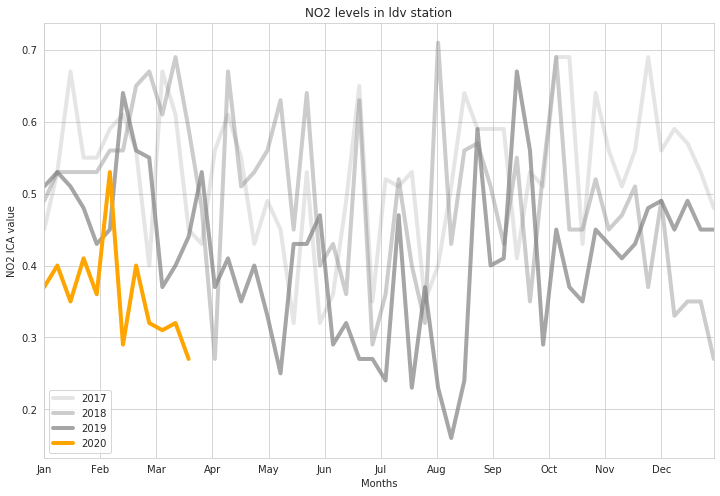

In [271]:
def group_year_by_weeks(df, year):
    return df[df.index.year == year].groupby(df[df.index.year == year].index.week).max()

df_2017 = group_year_by_weeks(df, 2017)
df_2018 = group_year_by_weeks(df, 2018)
df_2019 = group_year_by_weeks(df, 2019)
df_2020 = group_year_by_weeks(df, 2020)

def plot_year(gas):
    gas_name = gas.split('_')[0]
    station_id = gas.split('_')[1]
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.lineplot(data=df_2017, x=df_2019.index, y=gas, color='grey', alpha=0.2, linewidth=4, label="2017")
    ax = sns.lineplot(data=df_2018, x=df_2019.index, y=gas, color='grey', alpha=0.4, linewidth=4, label="2018")
    ax = sns.lineplot(data=df_2019, x=df_2019.index, y=gas, color='grey', alpha=0.7, linewidth=4, label="2019")
    ax = sns.lineplot(data=df_2020, x=df_2020.index, y=gas, color='orange', linewidth=4, label="2020")
    ax.set_xlim(1, 52)
    ax.set_xticks(np.linspace(1, 48, 12))
    ax.set_xlabel('Months')
    ax.set_ylabel('{} ICA value'.format(gas_name))
    ax.set_xticklabels(months)
    ax.set_title('{} levels in {} station'.format(gas_name, station_id))
    
plot_year('NO2_ldv')

And it looks like this is true for some of the cases!
However, the whole year 2020 generally presents lower levels of these pollutants, and its hard to say if the decrease around the month of March is truly attributable to coronavirus.